In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-23 00:54:13.303376: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 00:54:13.315537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 00:54:13.327921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 00:54:13.331690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 00:54:13.342127: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


2024-10-23 00:54:18.662531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:45:00.0, compute capability: 8.0
2024-10-23 00:54:18.664132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-10-23 00:54:18.665496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:49:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 31, 
                transposed_midpoints_corrected[:, :, 1] * 31, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [5]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-4, weights_path=None, l1_reg=0.001, l2_reg=0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
        # CBAM Attention Block
        def cbam_block(input_tensor, reduction_ratio=16):
            """CBAM block, which includes channel and spatial attention"""
            # Channel Attention
            channel_attention = layers.GlobalAveragePooling2D()(input_tensor)
            channel_attention = layers.Reshape((1, 1, input_tensor.shape[-1]))(channel_attention)
            channel_attention = layers.Dense(input_tensor.shape[-1] // reduction_ratio, activation='relu')(channel_attention)
            channel_attention = layers.Dense(input_tensor.shape[-1], activation='sigmoid')(channel_attention)
            x = layers.Multiply()([input_tensor, channel_attention])

            # Spatial Attention
            avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
            max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
            concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
            spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
            x = layers.Multiply()([x, spatial_attention])

            return x
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        # x = cbam_block(x)  # Add CBAM block here

        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        # x = cbam_block(x)  # Add CBAM block here
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        # x = cbam_block(x)  # Add CBAM block here
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = cbam_block(x)  # Add CBAM block here
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/13KFixed_Mixed_5_32by32_95index.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


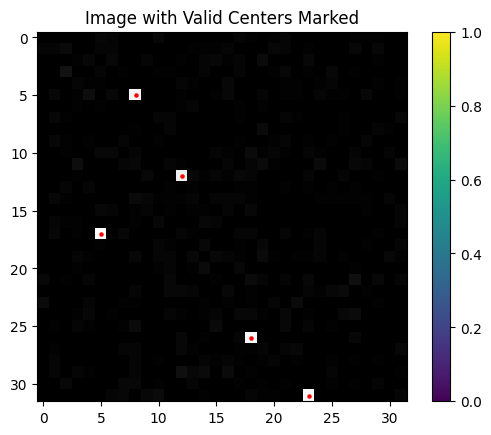

(<matplotlib.image.AxesImage at 0x7fb198444890>, 5282)

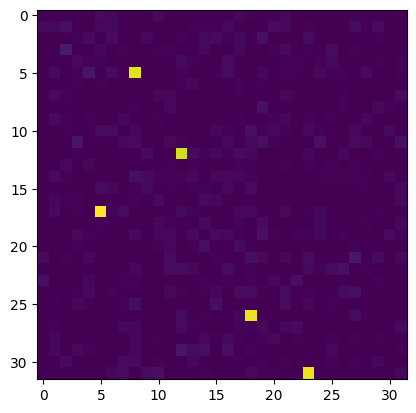

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

(<matplotlib.image.AxesImage at 0x7fb19036db10>, 5282)

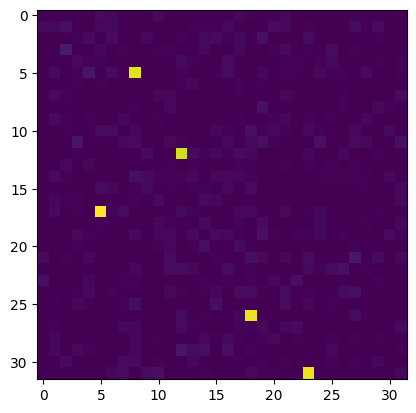

In [8]:
plt.imshow(images[l]),l

In [9]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1., 18.,  9.],
       [ 1.,  4., 18.],
       [ 1.,  6.,  8.],
       [ 1., 29., 21.],
       [ 1., 21., 11.]], dtype=float32)

In [10]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [11]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.0, 1.0)

In [12]:
np.max(centers)

31.0

In [13]:

batch_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (10400, 32, 32), Train Midpoints: (10400, 1, 5, 2)
Validation Images: (2600, 32, 32), Validation Midpoints: (2600, 1, 5, 2)


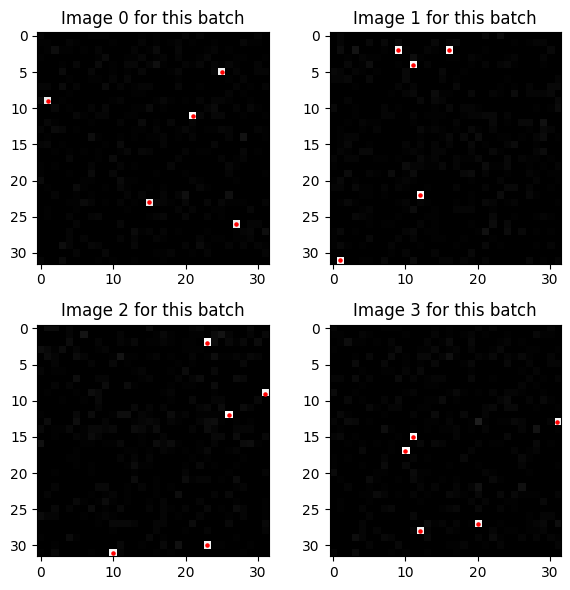

In [14]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [15]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=7e-6
)


In [16]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,234,186 (31.41 MB)

 Trainable params: 8,234,186 (31.41 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=3000,
    callbacks_list=[lr_scheduler]
)


Epoch 1/3000


2024-10-23 00:55:07.673424: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-23 00:55:07.685068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-23 00:55:07.711795: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729644907.771026  414025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644907.771026  414035 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644907.774123  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644907.822916  414025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644907.823002  414035 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644907.823145  414015 gpu_timer.c

 1/11 ━━━━━━━━━━━━━━━━━━━━ 2:35 16s/step - loss: 0.0961

W0000 00:00:1729644913.654583  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.655198  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.655386  414025 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.655768  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.656334  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.656908  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.657451  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.658112  414013 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644913.658741  414013 gp

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0963

2024-10-23 00:55:14.183977: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-23 00:55:14.184172: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2024-10-23 00:55:14.184568: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
W0000 00:00:1729644914.209335  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644914.209808  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644914.210142  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be re

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0962

W0000 00:00:1729644915.815772  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.815855  414004 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.815868  414005 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.816542  414004 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.816577  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.816655  414005 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.817323  414004 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.817360  414015 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644915.817433  414005 gp

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 689ms/step - loss: 0.0961 - val_loss: 0.0875 - learning_rate: 1.0000e-04
Epoch 2/3000


W0000 00:00:1729644920.555653  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.556421  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.557187  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.557953  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.558738  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.559573  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.560413  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.561274  414028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729644920.562097  414028 gp

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0795

2024-10-23 00:55:21.268562: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0792 - val_loss: 0.0724 - learning_rate: 1.0000e-04
Epoch 3/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0729 - val_loss: 0.0701 - learning_rate: 1.0000e-04
Epoch 4/3000


2024-10-23 00:55:22.758986: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0691 - val_loss: 0.0670 - learning_rate: 1.0000e-04
Epoch 5/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0625 - val_loss: 0.0522 - learning_rate: 1.0000e-04
Epoch 6/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0550

2024-10-23 00:55:24.851901: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0550 - val_loss: 0.0472 - learning_rate: 1.0000e-04
Epoch 7/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0476 - val_loss: 0.0419 - learning_rate: 1.0000e-04
Epoch 8/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0409 - val_loss: 0.0370 - learning_rate: 1.0000e-04
Epoch 9/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0330 - val_loss: 0.0273 - learning_rate: 1.0000e-04
Epoch 10/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0294 - val_loss: 0.0277 - learning_rate: 1.0000e-04
Epoch 11/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0270 - val_loss: 0.0268 - learning_rate: 1.0000e-04
Epoch 12/3000


2024-10-23 00:55:30.678217: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0242 - val_loss: 0.0247 - learning_rate: 1.0000e-04
Epoch 13/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0228 - val_loss: 0.0232 - learning_rate: 1.0000e-04
Epoch 14/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0214 - val_loss: 0.0226 - learning_rate: 1.0000e-04
Epoch 15/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0203 - val_loss: 0.0209 - learning_rate: 1.0000e-04
Epoch 16/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0196 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 17/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0188 - val_loss: 0.0188 - learning_rate: 1.0000e-04
Epoch 18/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0183 - val_loss: 0.0187 - learning_rate: 1.0000e-04
Epoch 19/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0179 - val_loss: 0.0182 - learning_rate: 1.0000e-04
Epoch 20/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0171 - val_loss: 0.

2024-10-23 00:55:41.298140: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0163 - val_loss: 0.0172 - learning_rate: 1.0000e-04
Epoch 23/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0159 - val_loss: 0.0174 - learning_rate: 1.0000e-04
Epoch 24/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0154 - val_loss: 0.0166 - learning_rate: 1.0000e-04
Epoch 25/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0153 - val_loss: 0.0167 - learning_rate: 1.0000e-04
Epoch 26/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0148 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 27/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0148 - val_loss: 0.0161 - learning_rate: 1.0000e-04
Epoch 28/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0143 - val_loss: 0.0173 - learning_rate: 1.0000e-04
Epoch 29/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0143 - val_loss: 0.0147 - learning_rate: 1.0000e-04
Epoch 30/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0140 - val_loss: 0.0

2024-10-23 00:56:04.501451: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0109 - val_loss: 0.0134 - learning_rate: 1.0000e-04
Epoch 45/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0106 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 46/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0108 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 47/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0104 - val_loss: 0.0125 - learning_rate: 1.0000e-04
Epoch 48/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0102 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 49/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0100 - val_loss: 0.0119 - learning_rate: 1.0000e-04
Epoch 50/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0100 - val_loss: 0.0117 - learning_rate: 1.0000e-04
Epoch 51/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0096 - val_loss: 0.0113 - learning_rate: 1.0000e-04
Epoch 52/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0096 - val_loss: 0

2024-10-23 00:56:48.810673: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0057 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 87/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0056 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 88/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0057 - val_loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 89/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0056 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 90/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0054 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 91/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0054 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 92/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0053 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 93/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0052 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 94/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0052 - val_loss: 0.

2024-10-23 00:58:14.698906: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0018 - val_loss: 0.0059 - learning_rate: 6.5610e-05
Epoch 173/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0018 - val_loss: 0.0062 - learning_rate: 6.5610e-05
Epoch 174/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0018 - val_loss: 0.0063 - learning_rate: 6.5610e-05
Epoch 175/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0018 - val_loss: 0.0070 - learning_rate: 6.5610e-05
Epoch 176/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0018 - val_loss: 0.0065 - learning_rate: 6.5610e-05
Epoch 177/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0018 - val_loss: 0.0066 - learning_rate: 6.5610e-05
Epoch 178/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0018 - val_loss: 0.0068 - learning_rate: 6.5610e-05
Epoch 179/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0017 - val_loss: 0.0062 - learning_rate: 6.5610e-05
Epoch 180/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0017 - val

2024-10-23 01:01:10.270997: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 6.0515e-04 - val_loss: 0.0064 - learning_rate: 1.2158e-05
Epoch 344/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 6.0696e-04 - val_loss: 0.0063 - learning_rate: 1.2158e-05
Epoch 345/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 6.0286e-04 - val_loss: 0.0058 - learning_rate: 1.2158e-05
Epoch 346/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 5.9922e-04 - val_loss: 0.0064 - learning_rate: 1.2158e-05
Epoch 347/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.9418e-04 - val_loss: 0.0057 - learning_rate: 1.2158e-05
Epoch 348/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 5.9245e-04 - val_loss: 0.0061 - learning_rate: 1.2158e-05
Epoch 349/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 5.9722e-04 - val_loss: 0.0061 - learning_rate: 1.2158e-05
Epoch 350/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.0146e-04
Epoch 350: ReduceLROnPlateau reducing learning rate to 1.0941898472083266e-05.
11/11 ━━━━━━

2024-10-23 01:05:56.174180: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.1665e-04 - val_loss: 0.0067 - learning_rate: 7.0000e-06
Epoch 685/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.1389e-04 - val_loss: 0.0061 - learning_rate: 7.0000e-06
Epoch 686/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.0950e-04 - val_loss: 0.0058 - learning_rate: 7.0000e-06
Epoch 687/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.1228e-04 - val_loss: 0.0061 - learning_rate: 7.0000e-06
Epoch 688/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.1142e-04 - val_loss: 0.0059 - learning_rate: 7.0000e-06
Epoch 689/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.1243e-04 - val_loss: 0.0068 - learning_rate: 7.0000e-06
Epoch 690/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 3.1142e-04 - val_loss: 0.0066 - learning_rate: 7.0000e-06
Epoch 691/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.0958e-04 - val_loss: 0.0059 - learning_rate: 7.0000e-06
Epoch 692/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59

2024-10-23 01:14:53.084649: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.0174e-05 - val_loss: 0.0061 - learning_rate: 7.0000e-06
Epoch 1368/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.1402e-05 - val_loss: 0.0069 - learning_rate: 7.0000e-06
Epoch 1369/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.1482e-05 - val_loss: 0.0069 - learning_rate: 7.0000e-06
Epoch 1370/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.8986e-05 - val_loss: 0.0066 - learning_rate: 7.0000e-06
Epoch 1371/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.9962e-05 - val_loss: 0.0063 - learning_rate: 7.0000e-06
Epoch 1372/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 8.8623e-05 - val_loss: 0.0066 - learning_rate: 7.0000e-06
Epoch 1373/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 8.9100e-05 - val_loss: 0.0067 - learning_rate: 7.0000e-06
Epoch 1374/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 9.1629e-05 - val_loss: 0.0067 - learning_rate: 7.0000e-06
Epoch 1375/3000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:32:40.282452: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.0614e-05 - val_loss: 0.0075 - learning_rate: 7.0000e-06
Epoch 2734/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.1289e-05 - val_loss: 0.0071 - learning_rate: 7.0000e-06
Epoch 2735/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.0089e-05 - val_loss: 0.0073 - learning_rate: 7.0000e-06
Epoch 2736/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.0628e-05 - val_loss: 0.0073 - learning_rate: 7.0000e-06
Epoch 2737/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 2.0158e-05 - val_loss: 0.0073 - learning_rate: 7.0000e-06
Epoch 2738/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.8772e-05 - val_loss: 0.0070 - learning_rate: 7.0000e-06
Epoch 2739/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.8434e-05 - val_loss: 0.0073 - learning_rate: 7.0000e-06
Epoch 2740/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.9602e-05 - val_loss: 0.0071 - learning_rate: 7.0000e-06
Epoch 2741/3000
11/11 ━━━━━━━━━━━━━━━━━━

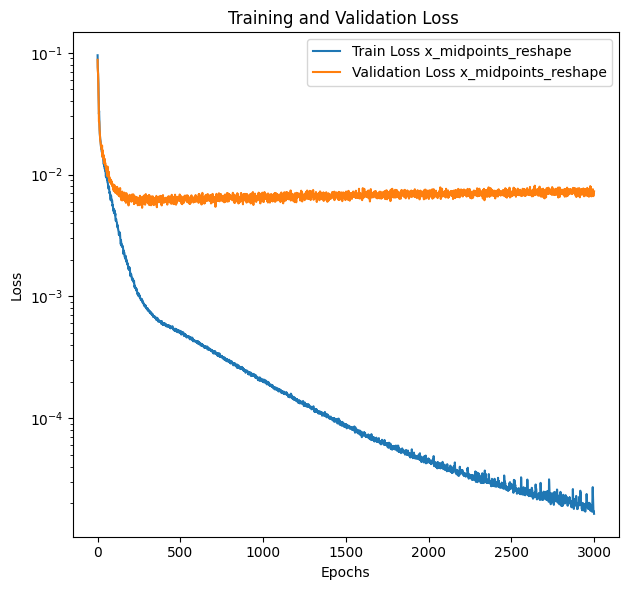

In [18]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
model_builder.model.save("/home/da886/Analysis/13KFixed_Mixed_5_32by32_95index-best.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions =model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


W0000 00:00:1729696519.681444  413893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.681483  413937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.682174  413895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.682819  413893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.682890  413937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.683060  413895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.683563  413893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.683648  413937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.683813  413895 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


W0000 00:00:1729696519.882599  413893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.882611  413895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.883570  413895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.884792  413893 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.885725  413895 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.886145  413937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.886470  413937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.886802  413937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696519.887121  413937 gp

Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing batch 13, batch sh

In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [20]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 13, 2), (9600, 1, 13, 2))

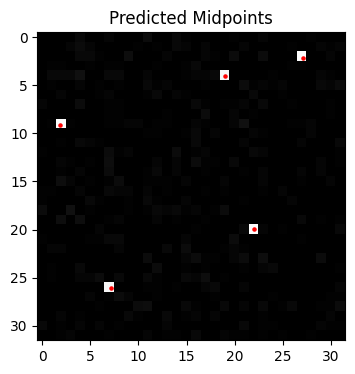

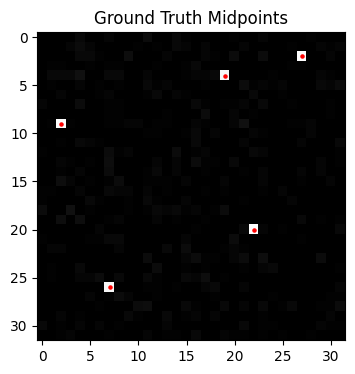

In [25]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [32]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(0.0009482383, 30.999704)

In [39]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[ 4.2590027,  3.908059 ],
         [27.263153 ,  4.3831873],
         [ 5.8743353,  6.6574388],
         [14.020337 ,  8.760142 ],
         [ 4.1754484, 10.7192545],
         [ 4.123699 , 11.2907295],
         [22.326601 , 11.401616 ],
         [ 7.203351 , 12.493043 ],
         [ 5.814977 , 12.613149 ],
         [21.202332 , 14.556165 ],
         [ 8.0557995, 17.444569 ],
         [ 8.055367 , 18.544151 ],
         [ 5.2744675, 26.596989 ]]], dtype=float32),
 array([[[ 4.,  3.],
         [28.,  6.],
         [ 6.,  7.],
         [14.,  9.],
         [ 4., 10.],
         [ 4., 10.],
         [22., 11.],
         [ 7., 12.],
         [ 6., 14.],
         [21., 15.],
         [ 8., 17.],
         [ 8., 18.],
         [ 5., 28.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

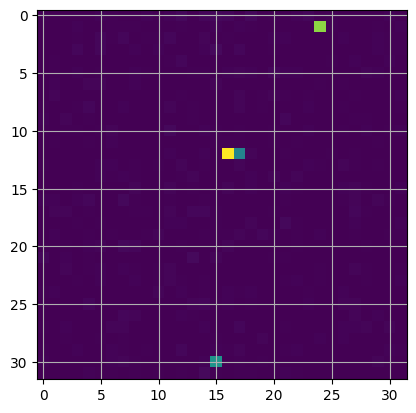

In [44]:
plt.imshow(images[2],)
plt.grid(True)

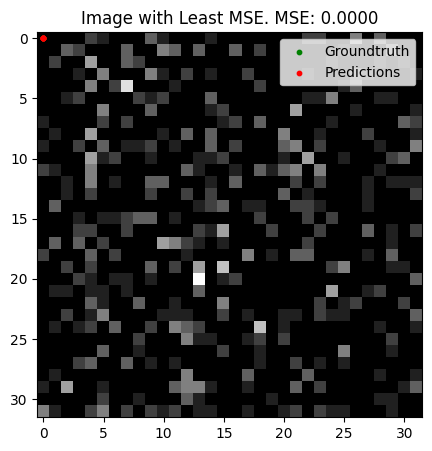

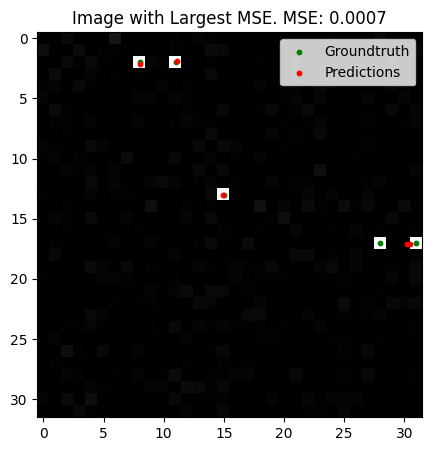

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266